
Training architecture: Two-node hidden layer [2, 2, 1]


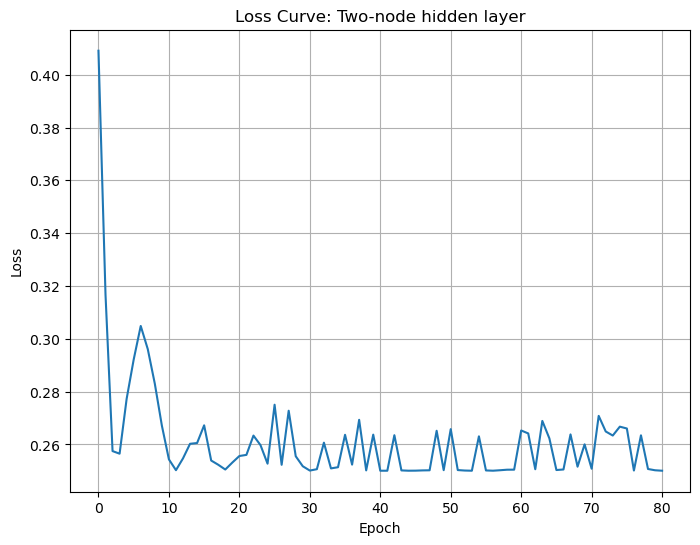

Saved: figures\loss_Two-node_hidden_layer.png


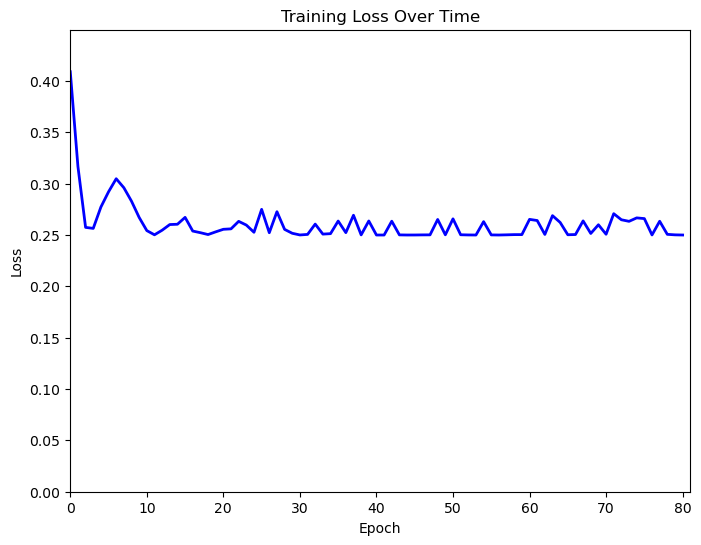

Saved animation: figures\loss_anim_Two-node_hidden_layer.gif

Training architecture: Three-node hidden layer [2, 3, 1]


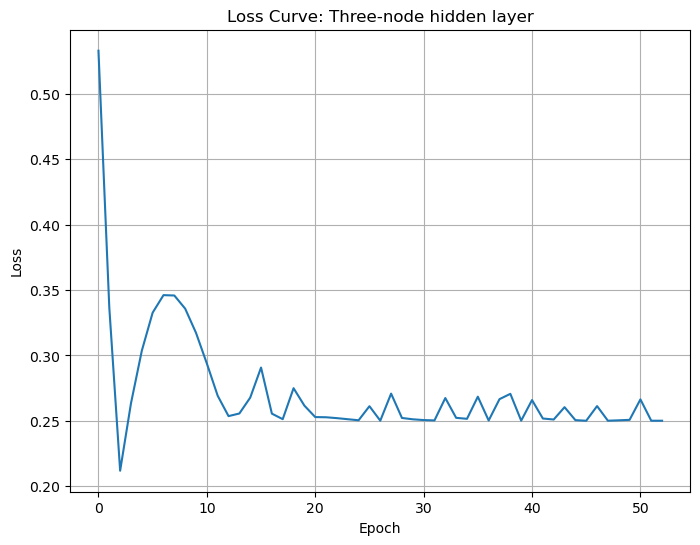

Saved: figures\loss_Three-node_hidden_layer.png


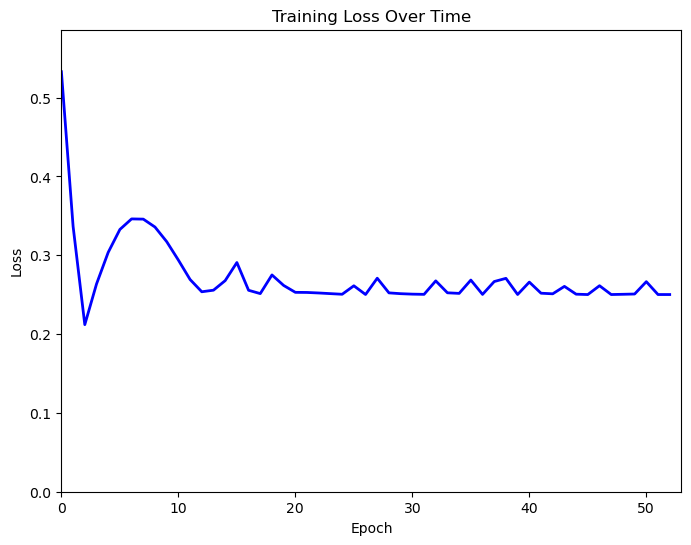

Saved animation: figures\loss_anim_Three-node_hidden_layer.gif

Training architecture: Two hidden layers (2 nodes each) [2, 2, 2, 1]


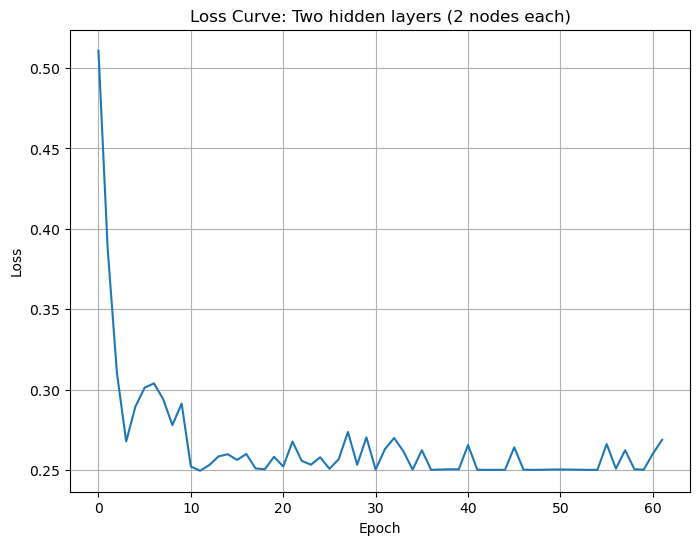

Saved: figures\loss_Two_hidden_layers_(2_nodes_each).png


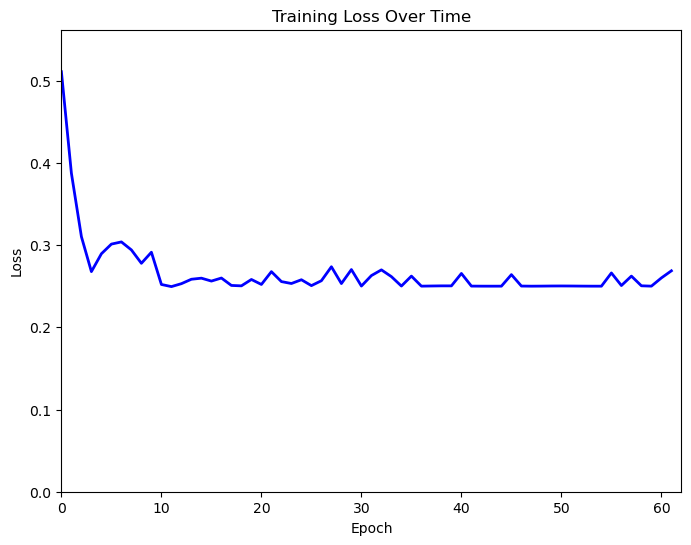

Saved animation: figures\loss_anim_Two_hidden_layers_(2_nodes_each).gif


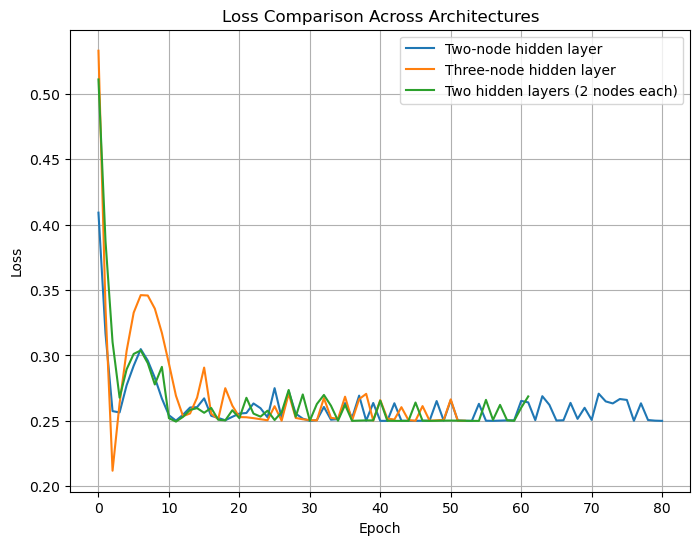

Saved: figures\loss_comparison.png


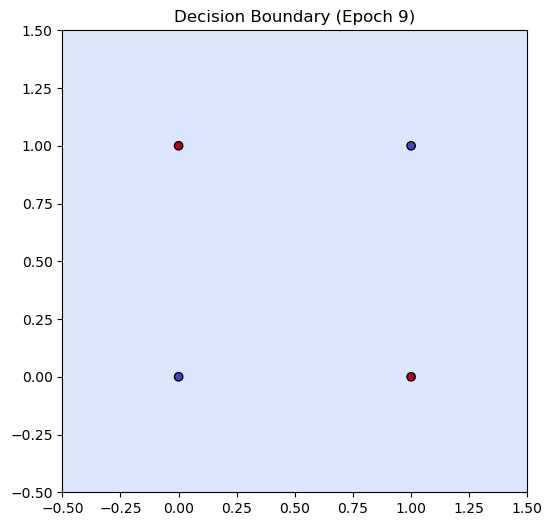

Saved animation: figures\decision_boundary.gif
All training runs complete. Static plots and GIFs saved in 'figures/' folder.


In [1]:
# From-Scratch Neural Network Lab: Architecture Comparisons, Plots & Animations

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Output folder
os.makedirs("figures", exist_ok=True)

def save_and_show(fig, filename):
    filepath = os.path.join("figures", filename)
    fig.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show(fig)
    print(f"Saved: {filepath}")

# Activation Functions
def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))
def sigmoid_derivative(a): return a * (1.0 - a)

def tanh(x): return np.tanh(x)
def tanh_derivative(a): return 1.0 - a**2

def relu(x): return np.maximum(0, x)
def relu_derivative(a): return (a > 0).astype(float)

ACT_FUNCS = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'tanh': (tanh, tanh_derivative),
    'relu': (relu, relu_derivative)
}

# Neuron
class Neuron:
    def __init__(self, weights, bias, activation='sigmoid'):
        self.weights = weights
        self.bias = bias
        self.activation_name = activation
        self.activation, self.activation_deriv = ACT_FUNCS[activation]
        
    def feedforward(self, inputs):
        self.z = np.dot(self.weights, inputs) + self.bias
        self.a = self.activation(self.z)
        return self.a

# Neural Network
class NeuralNetwork:
    def __init__(self, architecture, activation='sigmoid'):
        self.architecture = architecture
        self.layers = []
        self.activation_name = activation
        
        for i in range(len(architecture) - 1):
            layer_neurons = []
            for _ in range(architecture[i+1]):
                weights = np.random.randn(architecture[i]) * 0.1
                bias = np.random.randn() * 0.1
                layer_neurons.append(Neuron(weights, bias, activation))
            self.layers.append(layer_neurons)
        
        self.velocities_w = [[np.zeros_like(n.weights) for n in layer] for layer in self.layers]
        self.velocities_b = [[0.0 for _ in layer] for layer in self.layers]

    def feedforward(self, x):
        activations = [x]
        for layer in self.layers:
            layer_output = []
            for neuron in layer:
                layer_output.append(neuron.feedforward(activations[-1]))
            activations.append(np.array(layer_output))
        return activations[-1], activations

    def train(self, X, y, learning_rate=0.1, epochs=1000, batch_size=None,
              momentum=0.0, early_stopping=False, patience=10, tol=1e-4, verbose=False):
        
        y = np.array(y).reshape(-1, 1)
        losses = []
        best_loss = float('inf')
        patience_counter = 0
        
        n_samples = len(X)
        if batch_size is None:
            batch_size = n_samples
        
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            total_loss = 0.0
            
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                grad_w = [[np.zeros_like(n.weights) for n in layer] for layer in self.layers]
                grad_b = [[0.0 for _ in layer] for layer in self.layers]
                
                for input_data, target in zip(X_batch, y_batch):
                    output, all_activations = self.feedforward(input_data)
                    error = target - output
                    total_loss += np.sum(error**2)
                    
                    deltas = []
                    output_delta = error * ACT_FUNCS[self.activation_name][1](output)
                    deltas.append(output_delta)
                    
                    for i in range(len(self.layers)-2, -1, -1):
                        layer_deltas = []
                        current_activations = all_activations[i+1]
                        for j in range(len(self.layers[i])):
                            error_sum = sum(deltas[0][k] * self.layers[i+1][k].weights[j]
                                            for k in range(len(self.layers[i+1])))
                            delta = error_sum * ACT_FUNCS[self.activation_name][1](current_activations[j])
                            layer_deltas.append(delta)
                        deltas.insert(0, np.array(layer_deltas))
                    
                    for i in range(len(self.layers)):
                        for j in range(len(self.layers[i])):
                            if i == 0:
                                grad_w[i][j] += deltas[i][j] * input_data
                            else:
                                grad_w[i][j] += deltas[i][j] * all_activations[i]
                            grad_b[i][j] += deltas[i][j]
                
                for i in range(len(self.layers)):
                    for j in range(len(self.layers[i])):
                        self.velocities_w[i][j] = momentum * self.velocities_w[i][j] + (learning_rate / batch_size) * grad_w[i][j]
                        self.velocities_b[i][j] = momentum * self.velocities_b[i][j] + (learning_rate / batch_size) * grad_b[i][j]
                        self.layers[i][j].weights += self.velocities_w[i][j]
                        self.layers[i][j].bias += self.velocities_b[i][j]
            
            epoch_loss = total_loss / n_samples
            losses.append(epoch_loss)
            
            if early_stopping:
                if epoch_loss + tol < best_loss:
                    best_loss = epoch_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        if verbose:
                            print(f"Early stopping at epoch {epoch}")
                        break
        
        return losses

    def predict(self, X):
        predictions = []
        for x in X:
            output, _ = self.feedforward(x)
            predictions.append(output[0])
        return predictions

# Animation Helpers
def animate_loss(losses, filename):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, len(losses))
    ax.set_ylim(0, max(losses) * 1.1)
    ax.set_title("Training Loss Over Time")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    line, = ax.plot([], [], lw=2, color='blue')

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        x = list(range(frame + 1))
        y = losses[:frame + 1]
        line.set_data(x, y)
        return line,

    ani = FuncAnimation(fig, update, frames=len(losses), init_func=init,
                        blit=True, interval=50)
    gif_path = os.path.join("figures", filename)
    ani.save(gif_path, writer=PillowWriter(fps=20))
    plt.show(fig)
    print(f"Saved animation: {gif_path}")

def animate_decision_boundary(nn, X, y, filename):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    fig, ax = plt.subplots(figsize=(6, 6))

    def update(frame):
        ax.clear()
        Z = np.array([nn.predict([point])[0] for point in np.c_[xx.ravel(), yy.ravel()]])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, cmap='coolwarm')
        ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', edgecolors='k')
        ax.set_title(f"Decision Boundary (Epoch {frame})")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    ani = FuncAnimation(fig, update, frames=10, interval=500)
    gif_path = os.path.join("figures", filename)
    ani.save(gif_path, writer=PillowWriter(fps=2))
    plt.show(fig)
    print(f"Saved animation: {gif_path}")

# Run Multiple Architectures
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

architectures = [
    ([2, 2, 1], 'Two-node hidden layer'),
    ([2, 3, 1], 'Three-node hidden layer'),
    ([2, 2, 2, 1], 'Two hidden layers (2 nodes each)')
]

all_losses = {}

for arch, label in architectures:
    print(f"\nTraining architecture: {label} {arch}")
    nn = NeuralNetwork(arch, activation='tanh')
    losses = nn.train(X, y, learning_rate=0.1, epochs=2000, batch_size=2,
                      momentum=0.9, early_stopping=True, patience=50, verbose=False)
    all_losses[label] = losses

    # Static loss plot for this architecture
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(losses)
    ax.set_title(f"Loss Curve: {label}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    save_and_show(fig, f"loss_{label.replace(' ', '_')}.png")

    # Loss animation for this architecture
    animate_loss(losses, filename=f"loss_anim_{label.replace(' ', '_')}.gif")

# Compare Architectures 
fig, ax = plt.subplots(figsize=(8, 6))
for label, losses in all_losses.items():
    ax.plot(losses, label=label)
ax.set_title("Loss Comparison Across Architectures")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True)
save_and_show(fig, "loss_comparison.png")

# Decision Boundary Animation Example
# We'll animate for the last-trained network (two hidden layers)
nn_example = NeuralNetwork([2, 2, 2, 1], activation='tanh')
nn_example.train(X, y, learning_rate=0.1, epochs=200, batch_size=2,
                 momentum=0.9, early_stopping=False, verbose=False)

animate_decision_boundary(nn_example, X, y, filename="decision_boundary.gif")

print("All training runs complete. Static plots and GIFs saved in 'figures/' folder.")
